# Sarima Results

Below contains the results from the first pass at SARIMA modeling.

Feel free to scroll down to 'Analyzing Results'

In [1]:
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgb

In [2]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [3]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

df_surrounds = pd.read_pickle('1.collect_data/data_files/1hr_1block-average.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df_surrounds.reset_index(inplace=True)

blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')


In [4]:
df['Dummy'] = 0
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [5]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']



row_dicts = []

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results/arima.%d.pkl' % block
    if path.exists(block_file):
        
        # select only data for block, timeframe
        mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > (start_date))
        curr = df[mask].set_index('OccupancyDateTime')
        
        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()
        
        
        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
  
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()



        # caluclate arima smape error
        arima_smape = smape_error(preds, test)


        
        # Build a Gradient Boost Model, but with no parameters. This should just 'predict' as the mean value


        lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                                label=df_train['PercentOccupied'], 
                                feature_name=baseline_columns, 
                               params={'verbose': -1})
        lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                               label=df_test['PercentOccupied'], 
                               feature_name=baseline_columns, 
                               reference=lgb_train,
                              params={'verbose': -1})
        gbm = lgb.train(params,
                    lgb_train,
                   valid_sets=lgb_test,
                       verbose_eval=False)
        
        # calculate errors
        gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
        gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
        ar_rmse = np.sqrt(mean_squared_error(test, preds))
#         print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
#             arima_rmse, arima_smape, gbm_smape))
        

        #compare to within radius
        #df_surrounds
        s_mask = (df_surrounds['SourceElementKey'] == block) & (df_surrounds['OccupancyDateTime'] > (test.index[0]))
        s_curr = df_surrounds[s_mask].set_index('OccupancyDateTime')
        surrounds_test =  s_curr.PercentOccupied
        
        # Append Results
        row_dicts.append( {'SourceElementKey':block,
                                'ArimaSmapeErrors': arima_smape,
                                'GBMSmapeErrors':gbm_smape,
                                'TrainingSetLength':num_split,
                                 'ArimaRMSEs':ar_rmse,
                                 'ModelOrder':(mdl_dict['order'], mdl_dict['seasonal_order']),
                                 'TestVals':test,
                                 'ArimaPreds':preds,
                                 'GBMPreds':gbm_pred,
                                 'SurroundsTest':surrounds_test,
                                })


In [6]:
arima1_results = pd.DataFrame(row_dicts)
arima1_results.set_index('SourceElementKey', inplace=True)
#print(np.mean(arima_smapes), np.mean(gbm_smapes))

In [7]:
arima1_results[['ArimaSmapeErrors', 'GBMSmapeErrors']].mean()


ArimaSmapeErrors    28.496096
GBMSmapeErrors      27.951776
dtype: float64

In [8]:

arima1_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima1_results['ModelOrder'].tolist(), index=arima1_results.index) 
arima1_results[['p', 'd', 'q']] = pd.DataFrame(arima1_results['NonSeasonal'].tolist(), index=arima1_results.index)
arima1_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima1_results['Seasonal'].tolist(), index=arima1_results.index)



In [9]:
arima1_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,30.826775,34.434702,1427,0.233241,"((3, 1, 3), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.25770238599725415, 0.24653643153017435, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...,"(3, 1, 3)","(2, 0, 2, 10)",3,1,3,2,0,2,10
1002,30.916092,37.279208,1427,0.196573,"((1, 1, 1), (1, 0, 1, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.27159805632744266, 0.29349456991503353, 0.0...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...,"(1, 1, 1)","(1, 0, 1, 10)",1,1,1,1,0,1,10
1006,23.858915,33.132488,1696,0.172062,"((0, 0, 0), (4, 0, 2, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.5058257663304873, 0.342148345180791, 0.2369...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...,"(0, 0, 0)","(4, 0, 2, 12)",0,0,0,4,0,2,12
1009,35.346899,38.520762,1712,0.219138,"((1, 1, 1), (3, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.45847873893672186, 0.4364527174875548, 0.18...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...,"(1, 1, 1)","(3, 0, 3, 12)",1,1,1,3,0,3,12
1010,19.594693,24.154482,1712,0.226841,"((1, 1, 1), (1, 0, 1, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6189713903017217, 0.5709288061900901, 0.341...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...,"(1, 1, 1)","(1, 0, 1, 12)",1,1,1,1,0,1,12


In [10]:
arima1_results.describe()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,p,d,q,P,D,Q,m
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.0,68.000000,68.000000
mean,28.496096,27.951776,1650.411765,0.266081,1.088235,0.573529,1.073529,2.014706,0.0,1.941176,11.764706
std,16.282460,11.754722,196.432301,0.135769,1.102714,0.498241,0.982172,1.057915,0.0,1.091109,1.121269
min,9.519525,12.581694,1125.000000,0.104240,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,10.000000
25%,18.097644,19.780207,1428.000000,0.203976,0.000000,0.000000,0.000000,1.000000,0.0,1.000000,12.000000
50%,22.609537,24.410619,1713.000000,0.232431,1.000000,1.000000,1.000000,2.000000,0.0,2.000000,12.000000
75%,31.309491,33.458042,1713.000000,0.287225,1.250000,1.000000,1.250000,3.000000,0.0,2.250000,12.000000
max,92.033181,75.236908,1999.000000,1.061973,6.000000,1.000000,4.000000,4.000000,0.0,5.000000,14.000000


# Analyzing Results

Let's take a look at the results and see how the Sarima Results compare to predicting simply based on the mean (SIMPLE):

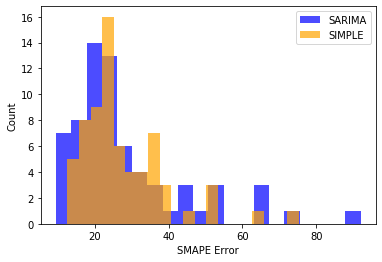

In [11]:
fig, ax = plt.subplots()
ax.hist(arima1_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima1_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='SIMPLE')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.show()

Looking at the figure above, it appears that using SARIMA gives better errors for some blocks, and worse errors for other blocks. I shall inspect the data further to see what may be causing this.

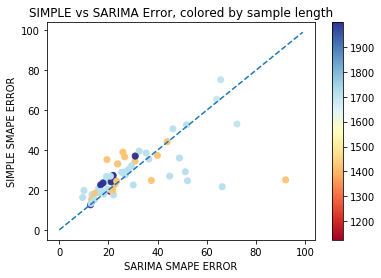

In [12]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima1_results['ArimaSmapeErrors'], 
                arima1_results['GBMSmapeErrors'], 
                c=arima1_results['TrainingSetLength'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by sample length')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

Above, sample size does not appear to be correlated with the error

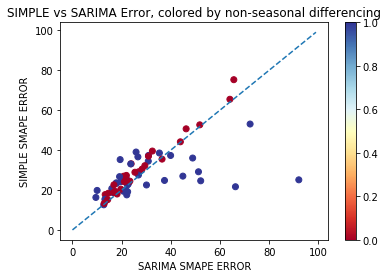

In [13]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima1_results['ArimaSmapeErrors'], 
                arima1_results['GBMSmapeErrors'], 
                c=arima1_results['d'], cmap=cm)
ax.set_title('SIMPLE vs SARIMA Error, colored by non-seasonal differencing')

ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

Above, the worst SARIMA model errors are those with a differencing of one. Potentially, allowing no differencing will improve these models. Below, we can see the mean errors for those with and without non-seasonal differencing.

In [14]:
arima1_results[arima1_results['d'] == 0][['ArimaSmapeErrors','GBMSmapeErrors']].mean()

ArimaSmapeErrors    27.367228
GBMSmapeErrors      30.457772
dtype: float64

In [15]:
arima1_results[arima1_results['d'] == 1][['ArimaSmapeErrors','GBMSmapeErrors']].mean()

ArimaSmapeErrors    29.335510
GBMSmapeErrors      26.088343
dtype: float64

## Inspecting some individual Blocks

#### Block A

In [16]:
ex_row = arima1_results[arima1_results['ArimaSmapeErrors'] < arima1_results['GBMSmapeErrors']].iloc[0]
ex_row.ModelOrder

((3, 1, 3), (2, 0, 2, 10))

Below is a block that the SARIMA model performs well with. It appears to capture the daily periodicity, but not the spikes on certain days.

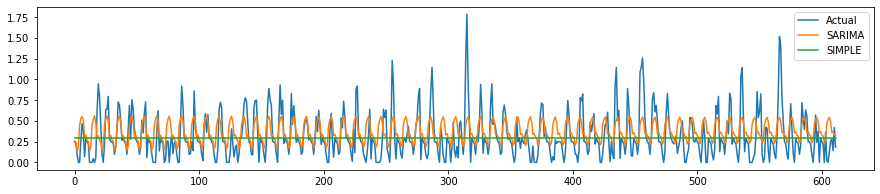

In [17]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals.values, label='Actual')
ax.plot(ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()


#### Block B

In [18]:
ex_row2 = arima1_results[arima1_results['ArimaSmapeErrors'] > arima1_results['GBMSmapeErrors']].iloc[0]
ex_row2.ModelOrder

((1, 0, 2), (1, 0, 1, 12))

Below is a block that the SARIMA model performs poorly with. The daily trend does not appear as regular as the block above.

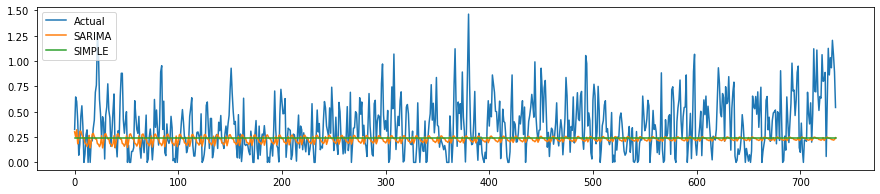

In [19]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row2.TestVals.values, label='Actual')
ax.plot(ex_row2.ArimaPreds, label='SARIMA')
ax.plot(ex_row2.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()

#### Block C

In [20]:
ex_row3 = arima1_results[(arima1_results['ArimaSmapeErrors'] - arima1_results['GBMSmapeErrors']) > 20].iloc[0]
ex_row3.ModelOrder

((0, 1, 0), (2, 0, 2, 12))

Below is a model with seasonal differencing = 1, which performs quite poorly. We can see that the mean is not trending downwards over time, which leads to a poor SARIMA model with d=1.

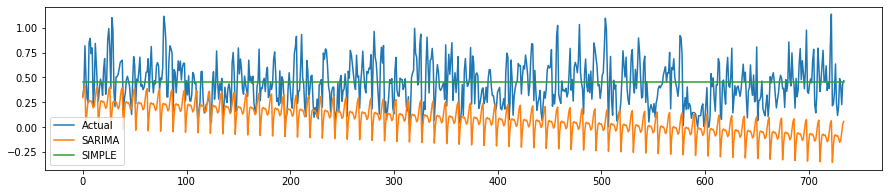

In [21]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row3.TestVals.values, label='Actual')
ax.plot(ex_row3.ArimaPreds, label='SARIMA')
ax.plot(ex_row3.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()

## Next Steps

Things I would like to test out:
   
   * Allowing no differencing (setting $d=0$)
   * Adding Exogenous regressors, to see if this can help predict the spikes (SARIMAX model)
   * Use Tree-based models to predict on the residuals from the SARIMA model
   
Things that may help even out the sharp, potentially random, peaks:

   * Predict based on blocks within certain radius. Potentially, an individual block cannot be predicted so accurately because people may choose to find parking within a certain radius, instead of a specific block.


In [22]:
arima1_results.columns

Index(['ArimaSmapeErrors', 'GBMSmapeErrors', 'TrainingSetLength', 'ArimaRMSEs',
       'ModelOrder', 'TestVals', 'ArimaPreds', 'GBMPreds', 'SurroundsTest',
       'NonSeasonal', 'Seasonal', 'p', 'd', 'q', 'P', 'D', 'Q', 'm'],
      dtype='object')

In [23]:
arima2_results = arima1_results.copy().drop(['NonSeasonal', 'Seasonal', 'p', 'd', 'q', 'P', 'D', 'Q', 'm'], axis=1)

In [24]:
arima2_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest
SourceElementKey,,,,,,,,,
1001,30.826775,34.434702,1427,0.233241,"((3, 1, 3), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.25770238599725415, 0.24653643153017435, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...
1002,30.916092,37.279208,1427,0.196573,"((1, 1, 1), (1, 0, 1, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.27159805632744266, 0.29349456991503353, 0.0...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...
1006,23.858915,33.132488,1696,0.172062,"((0, 0, 0), (4, 0, 2, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.5058257663304873, 0.342148345180791, 0.2369...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...
1009,35.346899,38.520762,1712,0.219138,"((1, 1, 1), (3, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.45847873893672186, 0.4364527174875548, 0.18...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...
1010,19.594693,24.154482,1712,0.226841,"((1, 1, 1), (1, 0, 1, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6189713903017217, 0.5709288061900901, 0.341...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...


In [25]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']


for block in arima2_results.index.values:
    block_file = 'arima_results2/arima.%d.pkl' % block
    if path.exists(block_file):
        arima2_results.loc[block]
        test = arima2_results.loc[block].TestVals
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()
        #print(type(preds), len(preds))
        
        arima2_results.at[block, 'ArimaPreds'] = preds
        arima2_results.at[block, 'ModelOrder'] = (mdl_dict['order'], mdl_dict['seasonal_order'])


        # caluclate arima smape error
        arima2_results.at[block, 'ArimaSmapeErrors'] = smape_error(preds, test.values)

        

        
        # calculate errors

        arima2_results.at[block, 'ArimaRMSEs'] = np.sqrt(mean_squared_error(test.values, preds))

#arima1_results['ArimaSmapeErrors_2'] =  arima2_smapes



In [26]:
arima2_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima2_results['ModelOrder'].tolist(), index=arima2_results.index) 
arima2_results[['p', 'd', 'q']] = pd.DataFrame(arima2_results['NonSeasonal'].tolist(), index=arima2_results.index)
arima2_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima2_results['Seasonal'].tolist(), index=arima2_results.index)


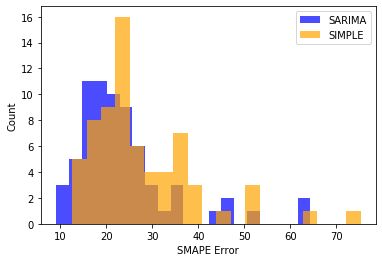

In [27]:
fig, ax = plt.subplots()
ax.hist(arima2_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima2_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='SIMPLE')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.show()

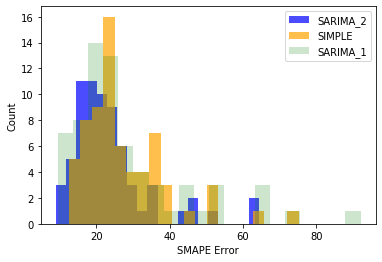

In [28]:
fig, ax = plt.subplots()
ax.hist(arima2_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA_2')
ax.hist(arima2_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='SIMPLE')
ax.hist(arima1_results['ArimaSmapeErrors'], bins=20, color = 'g', alpha = .2, label='SARIMA_1')

ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.show()

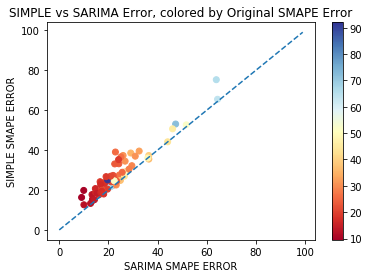

In [29]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima2_results['ArimaSmapeErrors'], 
                arima2_results['GBMSmapeErrors'], 
                c=arima1_results['ArimaSmapeErrors'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by Original SMAPE Error')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

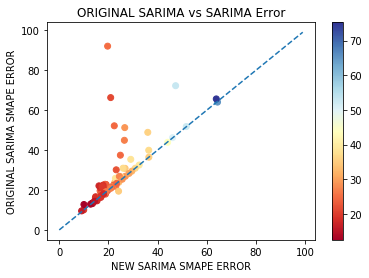

In [30]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima2_results['ArimaSmapeErrors'], 
                arima1_results['ArimaSmapeErrors'],
               c=arima2_results['GBMSmapeErrors'], cmap=cm)
ax.set_xlabel('NEW SARIMA SMAPE ERROR')
ax.set_ylabel('ORIGINAL SARIMA SMAPE ERROR')
ax.set_title('ORIGINAL SARIMA vs SARIMA Error')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

In [31]:
better_than_gbm = arima2_results[arima2_results['ArimaSmapeErrors'] < arima2_results['GBMSmapeErrors']]
row_idx = better_than_gbm.index.values[0]
ex_row_ar2 = better_than_gbm.iloc[0]
ex_row_ar2.ModelOrder

((0, 0, 3), (4, 0, 4, 10))

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


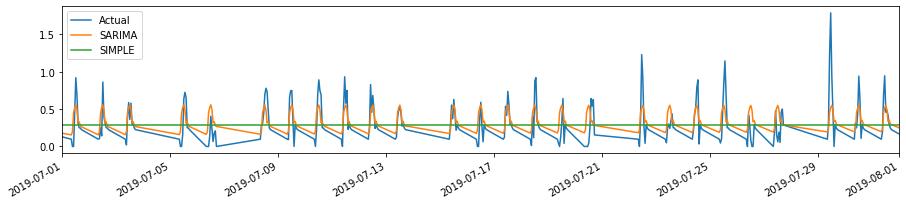

In [32]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='Actual')
# ax.plot(ex_row.SurroundsTest, label='Surrounds')
ax.plot(ex_row.TestVals.index, ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.TestVals.index, ex_row.GBMPreds, label='SIMPLE')
ax.set_xlim('2019-07-01', '2019-08-01')
fig.autofmt_xdate()
plt.legend()
plt.show()

To compare previous test with surrounds test, need dates (currently not there).

In [33]:
arima2_results.to_pickle('arima_results2/arima_results.pkl')
arima1_results.to_pickle('arima_results/arima_results.pkl')

# Arima Results with 1-block radius averaged observations

In [34]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']
df_surrounds['Dummy'] = 0


row_dicts = []

for block in blockface_detail.sourceelementkey.values:
    block_file = 'arima_results3/arima.%d.pkl' % block
    if path.exists(block_file):
        
        # select only data for block, timeframe
        mask = (df_surrounds['SourceElementKey'] == block) & (df_surrounds['OccupancyDateTime'] > (start_date))
        curr = df_surrounds[mask].set_index('OccupancyDateTime')
        
        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()
        
        
        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
  
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()



        # caluclate arima smape error
        arima_smape = smape_error(preds, test)


        
        # Build a Gradient Boost Model, but with no parameters. This should just 'predict' as the mean value


        lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                                label=df_train['PercentOccupied'], 
                                feature_name=baseline_columns, 
                               params={'verbose': -1})
        lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                               label=df_test['PercentOccupied'], 
                               feature_name=baseline_columns, 
                               reference=lgb_train,
                              params={'verbose': -1})
        gbm = lgb.train(params,
                    lgb_train,
                   valid_sets=lgb_test,
                       verbose_eval=False)
        
        # calculate errors
        gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
        gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
        ar_rmse = np.sqrt(mean_squared_error(test, preds))
#         print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
#             arima_rmse, arima_smape, gbm_smape))
        


        
        # Append Results
        row_dicts.append( {'SourceElementKey':block,
                                'ArimaSmapeErrors': arima_smape,
                                'GBMSmapeErrors':gbm_smape,
                                'TrainingSetLength':num_split,
                                 'ArimaRMSEs':ar_rmse,
                                 'ModelOrder':(mdl_dict['order'], mdl_dict['seasonal_order']),
                                 'TestVals':test,
                                 'ArimaPreds':preds,
                                 'GBMPreds':gbm_pred,
                                })


In [35]:
arima3_results = pd.DataFrame(row_dicts)
arima3_results.set_index('SourceElementKey', inplace=True)

In [36]:
arima3_results[['ArimaSmapeErrors', 'GBMSmapeErrors']].mean()


ArimaSmapeErrors    10.452048
GBMSmapeErrors      15.465288
dtype: float64

In [37]:
arima3_results[['NonSeasonal', 'Seasonal']] = pd.DataFrame(arima3_results['ModelOrder'].tolist(), index=arima3_results.index) 
arima3_results[['p', 'd', 'q']] = pd.DataFrame(arima3_results['NonSeasonal'].tolist(), index=arima3_results.index)
arima3_results[['P', 'D', 'Q', 'm']] = pd.DataFrame(arima3_results['Seasonal'].tolist(), index=arima3_results.index)


In [39]:
arima3_results = arima3_results.join(arima1_results.ArimaSmapeErrors, rsuffix='_org')

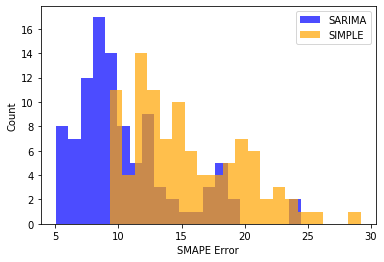

In [40]:
fig, ax = plt.subplots()
ax.hist(arima3_results['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(arima3_results['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='SIMPLE')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.show()

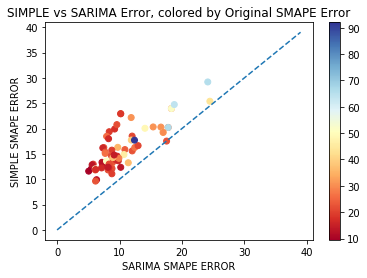

In [41]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['ArimaSmapeErrors_org'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by Original SMAPE Error')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')
plt.show()

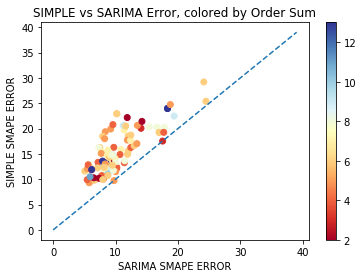

In [42]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(arima3_results['ArimaSmapeErrors'], 
                arima3_results['GBMSmapeErrors'], 
                c=arima3_results['P'] + arima3_results['Q'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by Order Sum')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(40), np.arange(40), '--')
plt.show()

In [43]:
better_than_gbm = arima3_results[arima3_results['ArimaSmapeErrors'] < arima3_results['GBMSmapeErrors']]
row_idx = better_than_gbm.index.values[0]
ex_row = better_than_gbm.iloc[0]
ex_row.ModelOrder

((0, 0, 0), (4, 0, 4, 12))

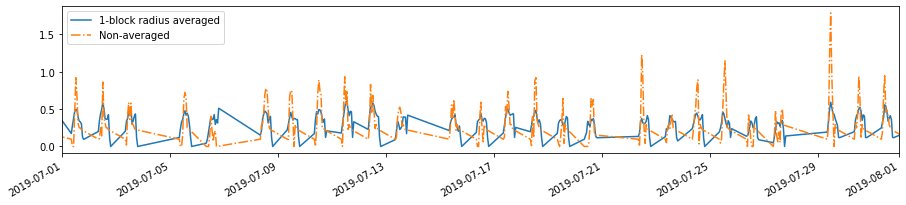

In [44]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='1-block radius averaged')
ax.plot(ex_row_ar2.TestVals, '-.', label='Non-averaged')

ax.set_xlim('2019-07-01', '2019-08-01')
fig.autofmt_xdate()
plt.legend()
plt.show()

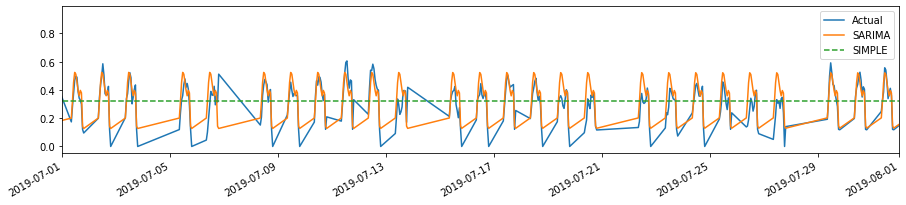

In [45]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals, label='Actual')
# ax.plot(ex_row.SurroundsTest, label='Surrounds')
ax.plot(ex_row.TestVals.index, ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.TestVals.index, ex_row.GBMPreds, '--', label='SIMPLE')
ax.set_xlim('2019-07-01', '2019-08-01')
fig.autofmt_xdate()
plt.legend()
plt.show()

In [46]:
arima3_results.to_pickle('arima_results3/arima_results.pkl')
